# Import Lib
Neural machine translation with a Transformer and Keras - https://www.tensorflow.org/text/tutorials/transformer#the_transformer

In [1]:
#!pip install tensorflow_text

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15,8]
import seaborn as sns
import plotly.graph_objects as go

In [239]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, Layer, MultiHeadAttention, LayerNormalization, Add, Dense, Dropout, Masking, BatchNormalization, Flatten
#from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.math import rsqrt, minimum
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.ops import round as tf_round

In [4]:
import math
import joblib

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, log_loss

In [6]:
from tensorflow.keras import initializers

initializer_for_relu = initializers.HeNormal() # For layers with activation function Relu
initializer_for_sigmoid = initializers.GlorotNormal() # For layers with activation function Sigmoid

In [7]:
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

## Import Data

In [12]:
# Mount google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
path = '/content/drive/MyDrive/MyColabProject/Data'
data_df = pd.read_csv(path+'/raw_nsepy_length40_vocab9.csv')
data_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-11,26,23,-5,0,10,0,12,-4,5,...,16,1,4,2,17,-6,16,4,-4,-2
1,-4,5,-10,0,-5,1,7,0,4,-2,...,-4,-2,15,23,20,-16,-6,-23,19,-4
2,-10,0,-5,1,7,0,4,-2,-8,-33,...,15,23,20,-16,-6,-23,19,-4,-10,4


In [14]:
data_df.shape

(40500, 40)

## Removing the Target Class 0

In [15]:
non0_data_df = data_df[data_df['39']!=0]
non0_data_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-11,26,23,-5,0,10,0,12,-4,5,...,16,1,4,2,17,-6,16,4,-4,-2
1,-4,5,-10,0,-5,1,7,0,4,-2,...,-4,-2,15,23,20,-16,-6,-23,19,-4
2,-10,0,-5,1,7,0,4,-2,-8,-33,...,15,23,20,-16,-6,-23,19,-4,-10,4


In [16]:
non0_data_df.shape

(33935, 40)

In [17]:
# frequency count of target column
non0_data_count = non0_data_df['39'].value_counts()
print(non0_data_count)

39
 1    5443
-1    5230
 2    5170
-2    4877
 3    3565
 4    3426
-3    3205
-4    3019
Name: count, dtype: int64


## Tokenizer - For Input Data

In [18]:
# Building Vocab
inp_vocab = np.arange(-45,45,1)
inp_vocab

array([-45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33,
       -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20,
       -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,
        -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,
         7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,
        20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44])

In [19]:
vocab_size_inp = inp_vocab.size
vocab_size_inp

90

In [20]:
# Creating Tokens
tokens_inp = np.arange(0,91,1)

In [21]:
val_token_pair_inp = {np.round(s,1):i for i,s in enumerate(inp_vocab)}
print(val_token_pair_inp)

{-45: 0, -44: 1, -43: 2, -42: 3, -41: 4, -40: 5, -39: 6, -38: 7, -37: 8, -36: 9, -35: 10, -34: 11, -33: 12, -32: 13, -31: 14, -30: 15, -29: 16, -28: 17, -27: 18, -26: 19, -25: 20, -24: 21, -23: 22, -22: 23, -21: 24, -20: 25, -19: 26, -18: 27, -17: 28, -16: 29, -15: 30, -14: 31, -13: 32, -12: 33, -11: 34, -10: 35, -9: 36, -8: 37, -7: 38, -6: 39, -5: 40, -4: 41, -3: 42, -2: 43, -1: 44, 0: 45, 1: 46, 2: 47, 3: 48, 4: 49, 5: 50, 6: 51, 7: 52, 8: 53, 9: 54, 10: 55, 11: 56, 12: 57, 13: 58, 14: 59, 15: 60, 16: 61, 17: 62, 18: 63, 19: 64, 20: 65, 21: 66, 22: 67, 23: 68, 24: 69, 25: 70, 26: 71, 27: 72, 28: 73, 29: 74, 30: 75, 31: 76, 32: 77, 33: 78, 34: 79, 35: 80, 36: 81, 37: 82, 38: 83, 39: 84, 40: 85, 41: 86, 42: 87, 43: 88, 44: 89}


In [22]:
# To return the token of -5
val_token_pair_inp[-5]

40

In [23]:
val_token_pair_inp[0]

45

In [24]:
token_val_pair_inp = {i:np.round(s,1) for i,s in enumerate(inp_vocab)}
print(token_val_pair_inp)

{0: -45, 1: -44, 2: -43, 3: -42, 4: -41, 5: -40, 6: -39, 7: -38, 8: -37, 9: -36, 10: -35, 11: -34, 12: -33, 13: -32, 14: -31, 15: -30, 16: -29, 17: -28, 18: -27, 19: -26, 20: -25, 21: -24, 22: -23, 23: -22, 24: -21, 25: -20, 26: -19, 27: -18, 28: -17, 29: -16, 30: -15, 31: -14, 32: -13, 33: -12, 34: -11, 35: -10, 36: -9, 37: -8, 38: -7, 39: -6, 40: -5, 41: -4, 42: -3, 43: -2, 44: -1, 45: 0, 46: 1, 47: 2, 48: 3, 49: 4, 50: 5, 51: 6, 52: 7, 53: 8, 54: 9, 55: 10, 56: 11, 57: 12, 58: 13, 59: 14, 60: 15, 61: 16, 62: 17, 63: 18, 64: 19, 65: 20, 66: 21, 67: 22, 68: 23, 69: 24, 70: 25, 71: 26, 72: 27, 73: 28, 74: 29, 75: 30, 76: 31, 77: 32, 78: 33, 79: 34, 80: 35, 81: 36, 82: 37, 83: 38, 84: 39, 85: 40, 86: 41, 87: 42, 88: 43, 89: 44}


In [25]:
# To return the value tokenized in 436
token_val_pair_inp[34]

-11

In [26]:
token_val_pair_inp[0]

-45

## Tokenizer - For Output Data

In [27]:
# Building Input Vocab
out_vocab = np.arange(-5,5,1)
out_vocab

array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4])

In [28]:
vocab_size_out = out_vocab.size
vocab_size_out

10

In [29]:
# Creating Tokens
tokens = np.arange(0,11,1)

In [30]:
val_token_pair_out = {np.round(s,1):i for i,s in enumerate(out_vocab)}
print(val_token_pair_out)

{-5: 0, -4: 1, -3: 2, -2: 3, -1: 4, 0: 5, 1: 6, 2: 7, 3: 8, 4: 9}


In [31]:
# To return the token of -5
val_token_pair_out[-4]

1

In [32]:
val_token_pair_out[0]

5

In [33]:
token_val_pair_out = {i : np.round(s,1) for i,s in enumerate(out_vocab)}
print(token_val_pair_out)

{0: -5, 1: -4, 2: -3, 3: -2, 4: -1, 5: 0, 6: 1, 7: 2, 8: 3, 9: 4}


In [34]:
# To return the value tokenized in 436
token_val_pair_out[3]

-2

In [35]:
token_val_pair_out[0]

-5

## Train Test Split
* Length of the input 39 <br>
* Length of Output and Context 1 <br>

In [36]:
inp_len = 39 # Length of the input
out_len = 1 # Length of Output and Context

In [37]:
test_percentage = 0.025
train_df, test_df = train_test_split(non0_data_df, test_size=test_percentage, random_state=1, shuffle=True)

In [38]:
print('Train shape',train_df.shape)
print('Test shape',test_df.shape)

Train shape (33086, 40)
Test shape (849, 40)


In [39]:
val_percentage = 0.3
train_df, val_df = train_test_split(train_df, test_size=val_percentage, random_state=1, shuffle=True)

In [40]:
print('Train shape',train_df.shape)
print('Validation shape',val_df.shape)
print('Test shape',test_df.shape)

Train shape (23160, 40)
Validation shape (9926, 40)
Test shape (849, 40)


Keras Model.fit training expects (inputs, labels) pairs. The inputs is tokenized sequences. The labels are the same sequences shifted by 1. This shift is so that at each location input sequence, the label in the next token.

In [41]:
X_train = train_df.drop(columns=train_df.columns[inp_len:].values).values
y_train = train_df.drop(columns=train_df.columns[:inp_len].values).values

X_val = val_df.drop(columns=val_df.columns[inp_len:].values).values
y_val = val_df.drop(columns=val_df.columns[:inp_len].values).values

X_test = test_df.drop(columns=test_df.columns[inp_len:].values).values
y_test = test_df.drop(columns=test_df.columns[:inp_len].values).values

In [42]:
print('X Train shape',X_train.shape)
#print('Context Train shape',c_train.shape)
print('Y Train shape',y_train.shape)
print('X Validation shape',X_val.shape)
#print('Context Validation shape',c_val.shape)
print('Y Validation shape',y_val.shape)
print('X Test shape',X_test.shape)
#print('Context Test shape',c_test.shape)
print('Y Test shape',y_test.shape)

X Train shape (23160, 39)
Y Train shape (23160, 1)
X Validation shape (9926, 39)
Y Validation shape (9926, 1)
X Test shape (849, 39)
Y Test shape (849, 1)


In [43]:
X_train[0]

array([ 2, -1, 13,  7, -5,  3,  2,  1,  2, -2,  2, -4,  3,  2, -1,  3,  2,
        0,  1,  1,  2, -1,  1,  4,  2, -1,  1,  2,  2, -2, -6,  2,  3,  2,
        3, -3,  2,  2, -2])

In [44]:
y_train[0]

array([-1])

## Tokenisation - For Input Data

In [45]:
# Tokenize the values
def tok_inp_data(inp_matrix):
  #count = 0
  tok_matrix = []
  for i in inp_matrix:
    tok_arr = []
    for j in i:
      tok_arr.append(val_token_pair_inp[j])
    #count+=1
    #print(count)
    tok_matrix.append(tok_arr)
  return np.array(tok_matrix)

In [46]:
X_train_tok = tok_inp_data(X_train)
X_train_tok[:3]

array([[47, 44, 58, 52, 40, 48, 47, 46, 47, 43, 47, 41, 48, 47, 44, 48,
        47, 45, 46, 46, 47, 44, 46, 49, 47, 44, 46, 47, 47, 43, 39, 47,
        48, 47, 48, 42, 47, 47, 43],
       [45, 44, 36, 53, 44, 49, 15, 52, 51, 45, 45, 66, 48, 41, 60, 43,
        48, 62, 49, 38, 25, 59, 38, 49, 43, 26, 50, 47, 43, 62, 83, 71,
        52, 25, 80, 16, 41, 50, 41],
       [31, 49, 45, 50, 53, 39, 34, 40, 45, 37, 53, 52, 44, 45, 38, 37,
        45, 37, 48, 41, 46, 54, 43, 43, 41, 46, 51, 47, 54, 40, 44, 46,
        52, 52, 47, 55, 36, 37, 38]])

In [47]:
X_test_tok = tok_inp_data(X_test)
X_test_tok[:3]

array([[43, 62, 54, 43, 36, 49, 45, 40, 36, 40, 41, 42, 55, 49, 77, 56,
        50, 88, 55, 39, 44, 45, 42, 55, 50, 45, 59, 26, 36, 48, 51, 56,
        25, 49, 45, 50, 43, 29, 53],
       [46, 45, 47, 57, 44, 52, 41, 47, 46, 51, 43, 47, 40, 48, 35, 54,
        44, 48, 45, 48, 45, 47, 41, 47, 49, 45, 45, 43, 44, 47, 43, 46,
        42, 34, 53, 48, 48, 40, 54],
       [50, 36, 52, 44, 43, 42, 48, 43, 48, 44, 43, 35, 51, 45, 36, 42,
        37, 55, 43, 45, 47, 45, 44, 43, 45, 40, 52, 39, 41, 45, 44, 42,
        44, 45, 45, 51, 45, 47, 47]])

In [48]:
X_val_tok = tok_inp_data(X_val)
X_val_tok[:3]

array([[47, 43, 46, 46, 48, 46, 46, 45, 46, 46, 45, 46, 44, 45, 44, 45,
        45, 45, 49, 48, 47, 46, 45, 42, 48, 42, 45, 47, 46, 49, 44, 44,
        42, 45, 49, 44, 48, 44, 47],
       [44, 43, 38, 47, 47, 43, 44, 47, 46, 44, 46, 41, 46, 46, 45, 41,
        47, 46, 46, 46, 43, 45, 43, 44, 44, 45, 43, 45, 50, 45, 47, 45,
        45, 44, 45, 44, 45, 43, 45],
       [53, 49, 47, 46, 45, 47, 46, 43, 41, 43, 46, 42, 44, 45, 43, 42,
        43, 45, 51, 59, 43, 46, 50, 49, 42, 46, 49, 41, 59, 46, 52, 43,
        43, 40, 44, 50, 39, 47, 46]])

## Tokenisation - For Output Data

In [49]:
# Tokenize the values
def tok_out_data(out_matrix):
  #count = 0
  tok_matrix = []
  for i in out_matrix:
    tok_arr = []
    for j in i:
      tok_arr.append(val_token_pair_out[j])
    #count+=1
    #print(count)
    tok_matrix.append(tok_arr)
  return np.array(tok_matrix)

In [50]:
y_train_tok = tok_out_data(y_train)
y_train_tok[:3]

array([[4],
       [7],
       [8]])

In [51]:
y_test_tok = tok_out_data(y_test)
y_test_tok[:3]

array([[1],
       [6],
       [4]])

In [52]:
y_val_tok = tok_out_data(y_val)
y_val_tok[:3]

array([[4],
       [3],
       [6]])

## Add Start and End Tokens
* Start token 1 <br>
* End token 89 <br>
* Padding token 0 <br>

In [53]:
txt = list(np.arange(1,10,1))
print(txt)
txt.insert(0, 512)
print(txt)
txt.insert(-1,1023)
print(txt)
txt.extend(list(np.zeros(3,int)))
print(txt)

[1, 2, 3, 4, 5, 6, 7, 8, 9]
[512, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[512, 1, 2, 3, 4, 5, 6, 7, 8, 1023, 9]
[512, 1, 2, 3, 4, 5, 6, 7, 8, 1023, 9, 0, 0, 0]


In [54]:
def Padding(data, pad_type, inp_len, out_len):
  start_tok = 1 # Start Token
  pad_tok = 0 # Padding Token
  end_tok = 89 # End Token

  n_data = list()
  inp_len +=1
  if pad_type == 'all':
    for row in data:
      row = list(row)
      #row.insert(0,start_tok)
      row.insert(inp_len,end_tok)
      n_data.append(row)
  if pad_type == 'end':
    for row in data:
      row = list(row)
      #row.insert(0,start_tok)
      #row.extend([pad_tok for num in range(inp_len - out_len)])
      n_data.append(row)
  if pad_type == 'padding':
    for row in data:
      row = list(row)
      #row.extend([pad_tok for num in range(inp_len - out_len)])
      row.insert(inp_len,pad_tok)
      n_data.append(row)
  return(np.array(n_data))

In [55]:
#for row in X_train:
#  print(list(row))

In [56]:
X_train_pad = Padding(X_train_tok, 'padding', inp_len, out_len)
print(X_train_pad.shape)
print(X_train_pad[0])
print(X_train_tok.shape)
print(X_train_tok[0])

(23160, 40)
[47 44 58 52 40 48 47 46 47 43 47 41 48 47 44 48 47 45 46 46 47 44 46 49
 47 44 46 47 47 43 39 47 48 47 48 42 47 47 43  0]
(23160, 39)
[47 44 58 52 40 48 47 46 47 43 47 41 48 47 44 48 47 45 46 46 47 44 46 49
 47 44 46 47 47 43 39 47 48 47 48 42 47 47 43]


In [57]:
#c_train_pad = Padding(c_train, 'end', inp_len, out_len)
#print(c_train_pad.shape)
#print(c_train_pad[0])
#print(c_train.shape)
#print(c_train[0])

In [58]:
#y_train_pad = Padding(y_train, 'end', inp_len, out_len)
#print(y_train_pad.shape)
#print(y_train_pad[0])
#print(y_train.shape)
#print(y_train[0])

In [59]:
X_val_pad = Padding(X_val_tok, 'padding', inp_len, out_len)
#c_val_pad = Padding(c_val, 'end', inp_len, out_len)
#y_val_pad = Padding(y_val, 'end', inp_len, out_len)
X_test_pad = Padding(X_test_tok, 'padding', inp_len, out_len)
#c_test_pad = Padding(c_test, 'end', inp_len, out_len)
#y_test_pad = Padding(y_test, 'end', inp_len, out_len)

In [60]:
print('X Train shape',X_train_pad.shape)
#print('Context Train shape',c_train_pad.shape)
#print('Y Train shape',y_train_pad.shape)
print('X Validation shape',X_val_pad.shape)
#print('Context Validation shape',c_val_pad.shape)
#print('Y Validation shape',y_val_pad.shape)
print('X Test shape',X_test_pad.shape)
#print('Context Test shape',c_test_pad.shape)
#print('Y Test shape',y_test_pad.shape)

X Train shape (23160, 40)
X Validation shape (9926, 40)
X Test shape (849, 40)


# Model Architecture <br>
* The querys is what you're trying to find.
* The keys what sort of information the dictionary has.
* The value is that information.


In [264]:
MAX_INP_TOKENS = vocab_size_inp
MAX_INP_LEN = X_train_pad.shape[1]

MAX_OUT_TOKENS = vocab_size_out
MAX_OUT_LEN = y_train_tok.shape[1]

In [265]:
print('Max Input Tokens =', MAX_INP_TOKENS)
print('Input Vocabulary =', vocab_size_inp)
print('Max Input Length =', MAX_INP_LEN)

print('Max Output Tokens =', MAX_OUT_TOKENS)
print('Output Vocabulary =', vocab_size_out)
print('Max Output Length =', MAX_OUT_LEN)

Max Input Tokens = 90
Input Vocabulary = 90
Max Input Length = 40
Max Output Tokens = 10
Output Vocabulary = 10
Max Output Length = 1


In [266]:
sample_num_layers = 2 # number of TransformerEncoderLayer layers (Original paper = 6)
sample_d_model = 8 # dimensionality of the embeddings (Original paper = 512)
sample_dff = 32  # dimensionality of the feed-forward network hidden layer (Original paper = 2048)
sample_num_heads = 2 # number of self-attention heads in the MultiheadAttention layer (Original paper = 8)
sample_dropout_rate = 0.2

## The embedding and positional encoding layer
It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

In [267]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = tf.experimental.numpy.arange(length, dtype=tf.float32)[:, tf.newaxis]
  depths = tf.experimental.numpy.arange(depth, dtype=tf.float32)[tf.newaxis, :]

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = tf.concat(
    [tf.math.sin(angle_rads), tf.math.cos(angle_rads)],
    axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

In [268]:
class PositionalEmbedding(Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.vocab_size = vocab_size
    self.embedding = Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=MAX_INP_LEN, depth=d_model)
    self.token_embedding = Embedding(vocab_size,d_model,mask_zero=True)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def build(self, input_shape):
    # Define weights
    self.kernel = self.add_weight(
        shape=((self.vocab_size, self.d_model)),
        initializer=initializer_for_relu,
        trainable=True
    )

  def call(self, x, mask=None):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

In [269]:
# Create an Embedding Object
embed_inp = PositionalEmbedding(vocab_size=vocab_size_inp, d_model=sample_d_model) # 8-dimensional (for small datasets)
embed_inp.build(X_train_pad[:3])
# Calling the function
inp_emb = embed_inp(X_train_pad[:3])
inp_emb_mask = inp_emb._keras_mask
print(inp_emb.shape)
print(inp_emb_mask.shape)

(3, 40, 8)
(3, 40)


In [270]:
# Testing the Embedding Object Function
inp_emb[0,:,0]

<tf.Tensor: shape=(40,), dtype=float32, numpy=
array([-0.04859478,  0.8502354 ,  0.79416656,  0.14748606, -0.83266866,
       -0.8808281 , -0.32801026,  0.57634157,  0.9407635 ,  0.51402617,
       -0.59261584, -1.0788708 , -0.45847672,  0.37157226,  0.9993718 ,
        0.7283841 , -0.3364981 , -0.88536036, -0.83163226,  0.06923218,
        0.8643505 ,  0.84542006, -0.08949634, -0.8797407 , -0.95417315,
       -0.1235873 ,  0.68191344,  0.9077812 ,  0.22231102, -0.5617262 ,
       -0.968289  , -0.45263243,  0.6295229 ,  0.9513171 ,  0.6071789 ,
       -0.41316274, -1.0403737 , -0.6921329 ,  0.39827624,  0.8568364 ],
      dtype=float32)>

In [271]:
inp_emb_mask[0]

<tf.Tensor: shape=(40,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False])>

In [272]:
# Calling the function
c_emb = embed_inp(X_train_pad[:3])
# To check if masking is enabled to the input
c_emb_mask = c_emb._keras_mask
print(c_emb.shape)
print(c_emb_mask.shape)

(3, 40, 8)
(3, 40)


In [273]:
print(c_emb._keras_mask[0])
print(c_emb[0,:,0])

tf.Tensor(
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False], shape=(40,), dtype=bool)
tf.Tensor(
[-0.04859478  0.8502354   0.79416656  0.14748606 -0.83266866 -0.8808281
 -0.32801026  0.57634157  0.9407635   0.51402617 -0.59261584 -1.0788708
 -0.45847672  0.37157226  0.9993718   0.7283841  -0.3364981  -0.88536036
 -0.83163226  0.06923218  0.8643505   0.84542006 -0.08949634 -0.8797407
 -0.95417315 -0.1235873   0.68191344  0.9077812   0.22231102 -0.5617262
 -0.968289   -0.45263243  0.6295229   0.9513171   0.6071789  -0.41316274
 -1.0403737  -0.6921329   0.39827624  0.8568364 ], shape=(40,), dtype=float32)


In [274]:
# Calling the function
y_emb = embed_inp(y_train_tok[:3])
print(y_emb.shape)

# To check if masking is enabled to the input
y_emb_mask = y_emb._keras_mask
print(y_emb_mask.shape)
y_emb_mask[2]

(3, 1, 8)
(3, 1)


<tf.Tensor: shape=(1,), dtype=bool, numpy=array([ True])>

(40, 8)


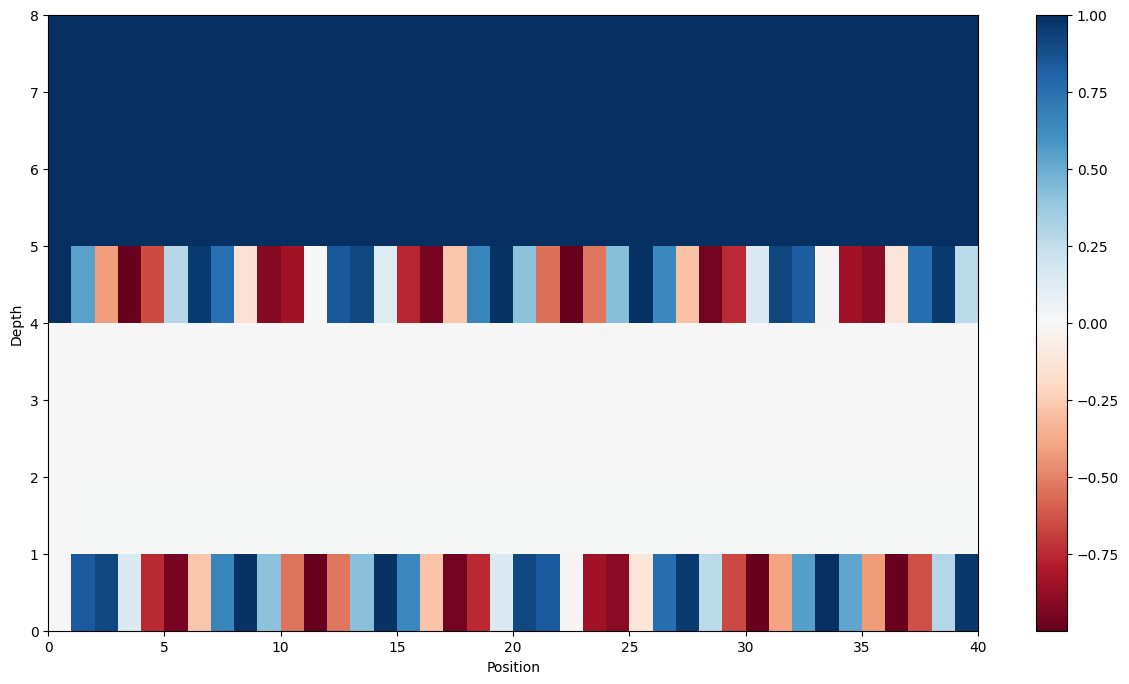

In [275]:
pos_encoding = positional_encoding(length=MAX_INP_LEN, depth=sample_d_model)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## Custom Attention Block

In [276]:
class BaseAttention(Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(**kwargs)
    self.layernorm = LayerNormalization()
    self.add = Add()
    #self.mask = Masking()

In [277]:
class CrossAttention(BaseAttention):

  def build(self, input_shape):
    ## Define weights
      self.kernel = self.add_weight(
          shape=(input_shape),
          initializer=initializer_for_relu,
          trainable=True)
      super(CrossAttention, self).build(input_shape)

  def call(self, key_val, query_context):
    attn_output, attn_scores = self.mha(
        query=query_context,  # The querys is what you're trying to find.
        key=key_val,  # The keys what sort of information the dictionary has.
        value=key_val, # The value is that information.
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([key_val,attn_output])
    x = self.layernorm(x)

    return x

In [278]:
# Text the class
sample_ca = CrossAttention(num_heads=sample_num_heads, key_dim=sample_d_model)

In [279]:
inp_emb._keras_mask.shape

TensorShape([3, 40])

In [280]:
inp_emb._keras_mask[:, tf.newaxis].shape

TensorShape([3, 1, 40])

In [281]:
print("input shape =",inp_emb.shape)
crossatt_out = sample_ca(key_val=inp_emb,query_context=inp_emb)
print("Cross attention shape =",crossatt_out.shape)

input shape = (3, 40, 8)
Cross attention shape = (3, 40, 8)


In [282]:
crossatt_out[0][0]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-1.417516  , -1.0408266 , -0.43660045, -0.7442322 ,  1.070806  ,
        0.91356397,  1.4502234 ,  0.2045815 ], dtype=float32)>

In [283]:
sample_ca.last_attn_scores[1,0:4,1,:]

<tf.Tensor: shape=(2, 40), dtype=float32, numpy=
array([[0.02698931, 0.02664356, 0.02562935, 0.02342311, 0.02382338,
        0.02522433, 0.02697003, 0.02740568, 0.02584034, 0.02412209,
        0.02371816, 0.02525764, 0.02608863, 0.0271746 , 0.0260622 ,
        0.02525125, 0.02339334, 0.02505076, 0.02596006, 0.0274188 ,
        0.0265644 , 0.02586015, 0.02407339, 0.02401107, 0.02629414,
        0.02748729, 0.02705747, 0.02547243, 0.02471822, 0.02447349,
        0.02510644, 0.0268636 , 0.02748641, 0.0259147 , 0.02467168,
        0.02424319, 0.02465156, 0.02641686, 0.02718684, 0.        ],
       [0.02470649, 0.02509968, 0.02568487, 0.02659497, 0.026806  ,
        0.02555938, 0.02477148, 0.02476207, 0.02553427, 0.02628835,
        0.02658843, 0.02618268, 0.02493942, 0.02449064, 0.02483539,
        0.02607296, 0.02649554, 0.02637735, 0.02514333, 0.02500874,
        0.02502132, 0.0257694 , 0.0269058 , 0.02627102, 0.02556971,
        0.02486561, 0.02505596, 0.02551414, 0.02640803, 0.02670981

## The global self-attention layer

In [284]:
class GlobalSelfAttention(BaseAttention):

  def build(self, input_shape):
    ## Define weights
      self.kernel = self.add_weight(
          shape=(input_shape),
          initializer=initializer_for_relu,
          trainable=True)
      super(GlobalSelfAttention, self).build(input_shape)

  def call(self, key_val):
    attn_output = self.mha(
        query=key_val,  # The querys is what you're trying to find.
        key=key_val,  # The keys what sort of information the dictionary has.
        value=key_val, # The value is that information.
        )
    x = self.add([key_val, attn_output])
    x = self.layernorm(x)
    return x

In [285]:
sample_gsa = GlobalSelfAttention(num_heads=sample_num_heads, key_dim=sample_d_model)

print(inp_emb.shape)
print(sample_gsa(inp_emb).shape)

(3, 40, 8)
(3, 40, 8)


In [286]:
globalatt_out = sample_gsa(inp_emb)

In [287]:
globalatt_out[0][0]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-1.3472972 , -0.46660137, -0.6224944 , -1.1288117 ,  1.413528  ,
        0.7501923 ,  0.09262502,  1.3088597 ], dtype=float32)>

In [288]:
globalatt_out._keras_mask[0]

<tf.Tensor: shape=(40,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False])>

## Masked Attention Layer <br>
Causal Self Attention

Transformers are an "autoregressive" model: They generate the text one token at a time and feed that output back to the input. To make this efficient, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".<br>
The causal mask ensures that each location only has access to the locations that come before it:

In [289]:
class CausalSelfAttention(BaseAttention):

  def build(self, input_shape):
    ## Define weights
      self.kernel = self.add_weight(
          shape=(input_shape),
          initializer=initializer_for_relu,
          trainable=True)
      super(CausalSelfAttention, self).build(input_shape)

  def call(self, context):#, num_heads):
    ##x = self.mask(x)
    ## Reshape for compatibility of Mask with attention layer
    #expanded_mask = context._keras_mask[:, tf.newaxis, tf.newaxis, :]  # Shape: (batch_size, 1, 1, seq_length)
    ## Now expand to (batch_size, num_heads, 1, L)
    #expanded_mask = tf.repeat(expanded_mask, num_heads, axis=1) # Shape: (batch_size, num_heads, 1, seq_length)

    # Now expand to (batch_size, seq_length, seq_length)
    context_mask = tf.expand_dims(context._keras_mask, axis=2) # Shape: (batch_size, seq_length, seq_length)

    attn_output, attn_scores = self.mha(
        query=context, # The querys is what you're trying to find.
        value=context, # The keys what sort of information the dictionary has.
        key=context, # The value is that information.
        use_causal_mask = True, # causal_mask is used to appropriately mask when computing the attention scores
        attention_mask = context_mask, # used to ignoring padding tokens
        return_attention_scores=True
        )
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    context = self.add([context, attn_output])
    context = self.layernorm(context)
    return context

In [290]:
print(inp_emb.shape)
print(inp_emb._keras_mask[:, tf.newaxis, tf.newaxis, :].shape)
# Now expand to (batch_size, num_heads, 1, L)
padding_mask = tf.repeat(inp_emb._keras_mask[:, tf.newaxis, tf.newaxis, :], sample_num_heads, axis=1)  # Shape: (batch_size, num_heads, 1, seq_length)
print(padding_mask.shape)

(3, 40, 8)
(3, 1, 1, 40)
(3, 2, 1, 40)


In [291]:
sample_csa = CausalSelfAttention(num_heads=sample_num_heads, key_dim=sample_d_model)
selfatt_out = sample_csa(context=inp_emb)
#selfatt_out = sample_csa(c_emb)

print(inp_emb.shape)
print(sample_csa.last_attn_scores.shape)
print(selfatt_out.shape)

(3, 40, 8)
(3, 2, 40, 40)
(3, 40, 8)


In [292]:
sample_csa.last_attn_scores[1,1:3,1,:]

<tf.Tensor: shape=(1, 40), dtype=float32, numpy=
array([[0.5031498, 0.4968501, 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ]], dtype=float32)>

In [293]:
selfatt_out[0,:,0]

<tf.Tensor: shape=(40,), dtype=float32, numpy=
array([-1.5043111 , -0.44216537, -0.27126914, -0.9493039 , -1.8890315 ,
       -2.1073432 , -1.7298377 , -0.8896871 , -0.06867397, -0.5625582 ,
       -1.6635234 , -2.1503284 , -1.8843839 , -1.0973576 ,  0.05138278,
       -0.31354147, -1.4189804 , -2.0173259 , -2.102029  , -1.469022  ,
       -0.32607067, -0.04525077, -1.2239983 , -2.0104527 , -2.108747  ,
       -1.6092334 , -0.7045064 , -0.05536532, -0.8345934 , -1.7073833 ,
       -2.1838427 , -1.8199143 , -0.8239122 , -0.05440784, -0.44474155,
       -1.3934389 , -2.1061418 , -1.9743888 , -1.0766928 , -0.41208184],
      dtype=float32)>

In [294]:
#out1 = sample_csa(embed_inp(X_train_pad[:, :3]))
#out2 = sample_csa(embed_inp(X_train_pad))[:, :3]

#tf.reduce_max(abs(out1 - out2)).numpy()

## Feed Forward Network Layer

In [295]:
class FeedForward(Layer):
  # dff - dence feed forward neurons
  # d_model - input shape
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = Sequential([
      Dense(dff, activation='relu',kernel_initializer=initializer_for_relu),
      Dense(d_model, activation='relu',kernel_initializer=initializer_for_relu),
      Dropout(dropout_rate)
    ])
    self.add = Add()
    self.layer_norm = LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [296]:
sample_ffn = FeedForward(sample_d_model, sample_dff)
sample_ffn_out = sample_ffn(inp_emb)
print(inp_emb.shape)
print(sample_ffn_out.shape)

(3, 40, 8)
(3, 40, 8)


In [297]:
sample_ffn_out[0,0,:8]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-0.83946484, -1.2240938 ,  0.22536731, -1.1674272 ,  0.1526041 ,
        0.12173367,  1.9139731 ,  0.81730795], dtype=float32)>

## Complete Encoder Layer

In [298]:
class EncoderLayer(Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, key_val):
    x = self.self_attention(key_val)
    x = self.ffn(x)
    return x

In [299]:
class Encoder(Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
      for _ in range(num_layers)]

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.dropout = Dropout(dropout_rate)

  def call(self, key_val):
    # `x` is token-IDs
    x = self.pos_embedding(key_val)
    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x

In [300]:
# Testing the encoder

# Instantiate the encoder.
sample_encoder = Encoder(num_layers=sample_num_layers,
                         d_model=sample_d_model,
                         num_heads=sample_num_heads,
                         dff=sample_dff,
                         vocab_size=vocab_size_inp)

In [301]:
sample_encoder_output = sample_encoder(X_train_pad[:3], training=False)
# Print the shape.
print(X_train_pad[:3].shape)
print(sample_encoder_output.shape)

(3, 40)
(3, 40, 8)


In [302]:
sample_encoder_output[0,0,:]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-1.4452426 , -1.371531  , -0.01482743,  1.4912796 , -0.06355757,
       -0.10492159,  1.3235474 ,  0.1852532 ], dtype=float32)>

## Complete Decoder Layer

Each DecoderLayer containing a CausalSelfAttention, a CrossAttention, and a FeedForward layer:

In [303]:
class DecoderLayer(Layer):
  def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_att = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate
    )

    #self.cross_att = CrossAttention(
    #    num_heads=num_heads,
    #    key_dim=d_model,
    #    dropout=dropout_rate
    #)

    self.ffn = FeedForward(d_model, dff)

  def call(self, key_val, query_context):
    self_att_out = self.causal_self_att(context=query_context)
    #cross_att_out = self.cross_att(key_val=key_val, query_context=self_att_out)

    # Cache the last attention scores for plotting later
    #self.last_attn_scores = self.cross_att.last_attn_scores

    fnn_out = self.ffn(self_att_out)

    return fnn_out


In [304]:
# Testing decoder layer

sample_decoder_layer = DecoderLayer(d_model=sample_d_model, num_heads=sample_num_heads, dff=sample_dff)

sample_decoder_layer_output = sample_decoder_layer(
    key_val=inp_emb, query_context=inp_emb)

In [305]:
sample_decoder_layer_output[0,0,:]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-1.4093928 , -1.337238  ,  0.46770522,  0.11963019, -0.5439044 ,
        1.0439725 ,  1.6119604 ,  0.04726681], dtype=float32)>

In [306]:
print(inp_emb.shape)
print(sample_decoder_layer_output.shape)

(3, 40, 8)
(3, 40, 8)


In [307]:
#sample_decoder_layer.last_attn_scores[0,0,0,:]

In [308]:
class Decoder(Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.decoder_layer = [DecoderLayer(
      d_model=d_model,
      num_heads=num_heads,
      dff=dff,
      dropout_rate=dropout_rate
    ) for _ in range(num_layers)]

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size_inp,
                                             d_model=d_model)

    self.dropout = Dropout(rate=dropout_rate)

    #self.last_attn_scores = None

    self.d_model = d_model
    self.num_layers = num_layers

  def call(self, key_val, query_context):
    query_context = self.pos_embedding(query_context)

    query_context = self.dropout(query_context)

    for i in range(self.num_layers):
      x  = self.decoder_layer[i](key_val=query_context, query_context=query_context)

    #self.last_attn_scores = self.decoder_layer[-1].last_attn_scores

    return x

In [309]:
# Test the decoder

# Instantiate the decoder.
sample_decoder = Decoder(num_layers=sample_num_layers,
                         d_model=sample_d_model,
                         num_heads=sample_num_heads,
                         dff=sample_dff,
                         vocab_size=vocab_size_inp)

sample_decoder_output = sample_decoder(
    key_val=inp_emb,
    query_context=X_train_pad[:3])

In [310]:
sample_decoder_output[0,:,0]

<tf.Tensor: shape=(40,), dtype=float32, numpy=
array([-1.0827422 ,  0.38421947,  0.8254781 ,  0.23950586, -1.145485  ,
       -1.898253  , -1.5395062 ,  0.22278398,  0.86897117,  0.4270597 ,
       -0.85442114, -1.9818377 , -1.5844287 , -0.85530096,  0.8869752 ,
        0.5396492 , -0.43789557, -1.817963  , -1.917508  , -0.9475616 ,
        0.52863055,  0.7183728 ,  0.15600708, -1.3087201 , -1.9582137 ,
       -1.4138119 ,  0.49622077,  0.8096147 ,  0.1369415 , -0.7994172 ,
       -1.8815237 , -1.6459367 , -0.36185163,  0.90020347,  0.4440573 ,
       -0.2512583 , -1.8583155 , -1.8275845 , -0.99548745,  0.82815146],
      dtype=float32)>

In [311]:
print(X_train_pad[:3].shape)
print(inp_emb.shape)
print(sample_decoder_output.shape)

(3, 40)
(3, 40, 8)
(3, 40, 8)


## Decoder Feed Forward Network Layer

In [312]:
class DecoderFeedForward(Layer):
  # dff - dence feed forward neurons
  # d_model - input shape
  def __init__(self, d_model, dropout_rate=0.1):
    super().__init__()
    self.seq = Sequential([
      Dense(d_model, activation='relu',kernel_initializer=initializer_for_relu),
      Dropout(dropout_rate),
      BatchNormalization(),
      Flatten()
    ])

  def call(self, x):
    x = self.seq(x)
    return x

In [313]:
sample_dffn = DecoderFeedForward(sample_d_model)
sample_dffn_out = sample_dffn(sample_decoder_output)
print(sample_decoder_output.shape)
print(sample_dffn_out.shape)

(3, 40, 8)
(3, 320)


In [314]:

sample_dffn_out[0,:]

<tf.Tensor: shape=(320,), dtype=float32, numpy=
array([0.        , 0.4345205 , 2.6792355 , 0.        , 0.        ,
       0.96236956, 0.18556947, 1.9964305 , 0.10622725, 0.64560246,
       2.8676615 , 0.        , 0.        , 0.        , 0.        ,
       0.73142046, 1.9446787 , 1.3314468 , 0.3618751 , 0.        ,
       0.        , 0.        , 0.        , 0.2018184 , 2.7420218 ,
       1.5052264 , 0.        , 0.        , 0.41995248, 0.        ,
       0.        , 0.44714114, 2.97163   , 1.1964977 , 0.        ,
       0.01370335, 0.        , 0.        , 0.        , 0.91695976,
       1.7900681 , 0.76002526, 0.4226816 , 0.        , 0.        ,
       0.40688735, 0.        , 1.3295143 , 0.77296096, 0.5610457 ,
       0.9215672 , 0.        , 0.        , 0.48062935, 0.        ,
       1.2751217 , 0.00432037, 0.52660805, 2.5491478 , 0.        ,
       0.        , 0.        , 0.        , 0.5800137 , 1.5669602 ,
       1.0650619 , 0.        , 0.        , 0.        , 0.        ,
       0.     

## Final Neural Network Layer

In [315]:
class FinalFeedForward(Layer):
  # dff - dence feed forward neurons
  # d_model - input shape
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = Sequential([
      Dense(d_model, activation='relu',kernel_initializer=initializer_for_relu),
      Dropout(dropout_rate),
      BatchNormalization(),
      Dense(dff, activation='relu',kernel_initializer=initializer_for_relu),
      Dropout(dropout_rate),
      BatchNormalization(),
      Dense(1, activation='relu',kernel_initializer=initializer_for_relu),
      Dropout(dropout_rate),
      BatchNormalization(),
      Flatten(),
      Dense(dff, activation='relu',kernel_initializer=initializer_for_relu),
      Dropout(dropout_rate)
    ])

  def call(self, x):
    x = self.seq(x)
    return x

In [316]:
# Testing the Final feed Forward layer
sample_ffl_layer = FinalFeedForward(d_model=sample_d_model, dff=sample_dff)
sample_ffl_layer_output = sample_ffl_layer(sample_decoder_layer_output)

print(sample_decoder_layer_output.shape)
print(sample_ffl_layer_output.shape)

(3, 40, 8)
(3, 32)


## Transformer

In [317]:
class Transformer(Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    #self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
    #                       num_heads=num_heads, dff=dff,
    #                       vocab_size=input_vocab_size,
    #                       dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)
    #self.decoder_feed_forward_layer = DecoderFeedForward(d_model=d_model)

    self.final_feed_forward_layer = FinalFeedForward(d_model=d_model,  dff=dff)
    #self.feed_forward_layer = FeedForward(d_model=d_model,  dff=dff)

    self.final_layer = Dense(target_vocab_size,kernel_initializer=initializer_for_sigmoid)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    key_val, query_context  = inputs

    #enc_out = self.encoder(key_val=key_val)  # (batch_size, context_len, d_model)

    dec_out = self.decoder(key_val=key_val, query_context=query_context)  # (batch_size, target_len, d_model)

    #dec_out = self.decoder_feed_forward_layer(dec_out)

    # Final linear layer output.
    ffl_out = self.final_feed_forward_layer(dec_out) # (batch_size, target_len, d_model)
    #ffl_out = self.feed_forward_layer(dec_out)

    logits = self.final_layer(ffl_out)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

## Custom Learning Rate

In [318]:
class CustomSchedule(LearningRateSchedule):
  def __init__(self, d_model, warmup_steps):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return rsqrt(self.d_model) * minimum(arg1, arg2)

In [319]:
sample_d_model**2

64

In [320]:
sample_warmup_steps = 10
sample_learning_rate = CustomSchedule(8, sample_warmup_steps)

sample_optimizer = Adam(sample_learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-8)

Text(0.5, 0, 'Train Step')

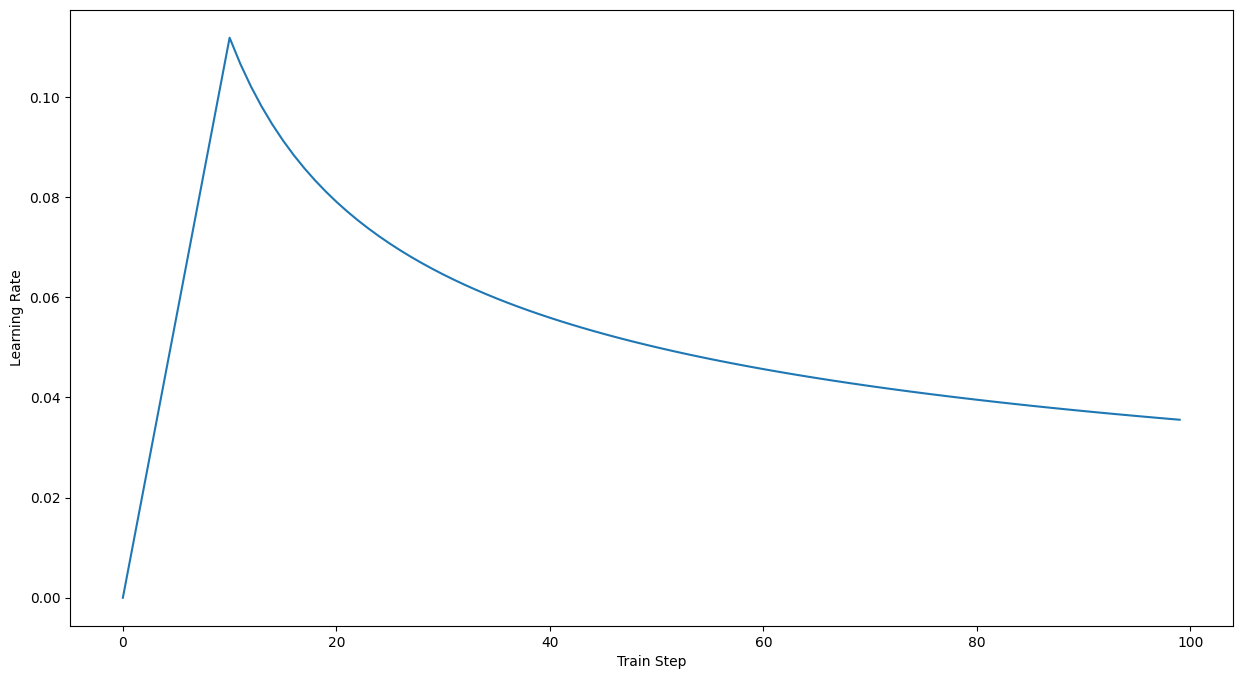

In [321]:
# Check the learning Rate
plt.plot(sample_learning_rate(tf.range(100, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

Learning rate per epoch:


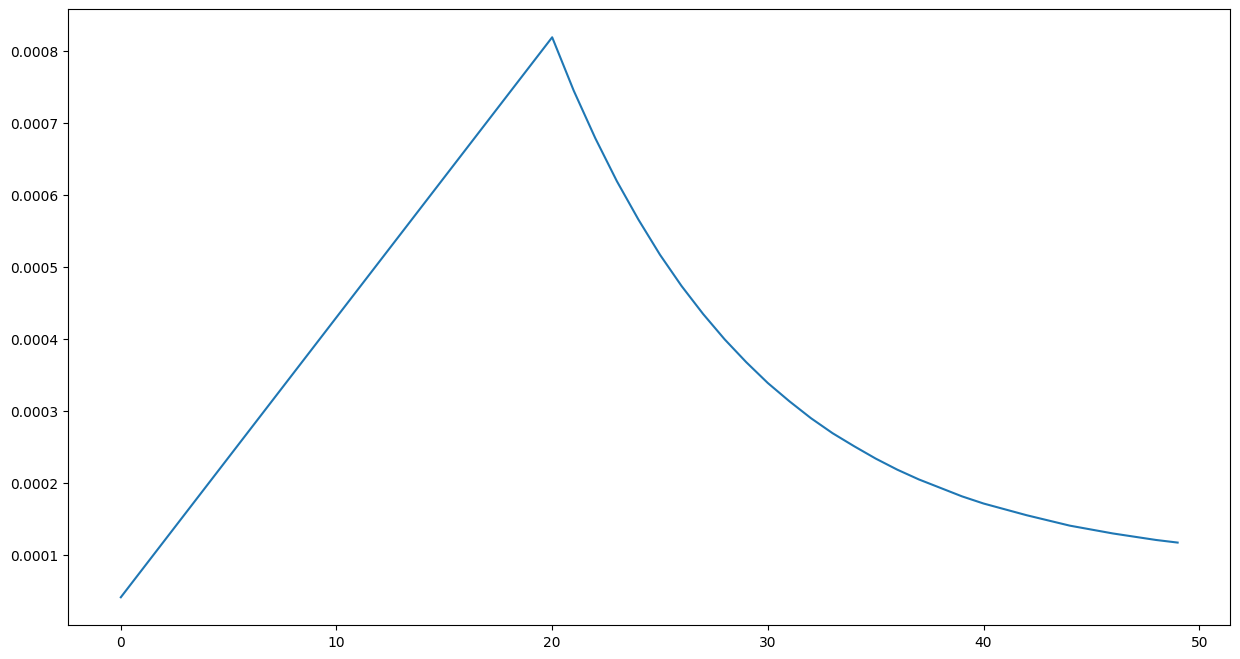

In [322]:
EPOCHS = 50
def lrfn(epoch):
  start_lr = tf.cast(0.00005, tf.float32) * math.exp(-0.1)
  min_lr = tf.cast(0.0001, tf.float32) * math.exp(-0.1)
  max_lr = tf.cast(0.001, tf.float32) * math.exp(-0.1)
  rampup_epochs = tf.cast(20, tf.float32)
  sustain_epochs = tf.cast(0, tf.float32)
  exp_decay = tf.cast(0.9, tf.float32)
  if epoch < rampup_epochs:
    return tf_round(tf.cast((max_lr - start_lr)/rampup_epochs * epoch + start_lr, tf.float32), 6) * math.exp(-0.1)
  elif epoch < rampup_epochs + sustain_epochs:
    return tf_round(tf.cast(max_lr, tf.float32), 6) * math.exp(-0.1)
  else:
    return tf_round(tf.cast((max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr, tf.float32), 6) * math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

## Set up the loss and metrics

In [323]:
'''
def masked_loss(label, pred):
  loss_object = MeanSquaredError()
  pred = tf.argmax(pred, axis=1)
  label = tf.cast(label, pred.dtype)
  loss = loss_object(label, pred)
  return loss
'''

def masked_loss(label, pred):
  mask = label != 0
  #loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='sum')
  #loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='sum_over_batch_size')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

'''
def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=1)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)
'''

def masked_accuracy(label, pred):
  accuracy_obj = SparseCategoricalAccuracy()
  score = accuracy_obj(label, pred)
  return score


In [324]:
'''
i = 7
j = 1
sample_label = y_test_pad[i,j]
print('smple y actuals = ',sample_label)
sample_pred = predictions_reconstructed_model[i,j]
print('smple y pred = ',sample_pred)
sample_loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='sum_over_batch_size')
sample_loss = sample_loss_object(sample_label, sample_pred)
print('Sample loss = ',sample_loss)
sample_masked_loss = masked_loss(sample_label, sample_pred)
print('Sample masked loss = ',sample_masked_loss)
#print('Sample masked accuracy = ', masked_accuracy(sample_label, sample_pred))
'''

"\ni = 7\nj = 1\nsample_label = y_test_pad[i,j]\nprint('smple y actuals = ',sample_label)\nsample_pred = predictions_reconstructed_model[i,j]\nprint('smple y pred = ',sample_pred)\nsample_loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='sum_over_batch_size')\nsample_loss = sample_loss_object(sample_label, sample_pred)\nprint('Sample loss = ',sample_loss)\nsample_masked_loss = masked_loss(sample_label, sample_pred)\nprint('Sample masked loss = ',sample_masked_loss)\n#print('Sample masked accuracy = ', masked_accuracy(sample_label, sample_pred))\n"

# Model 1

## Model building

In [325]:
#Define a model with Transformer layer
tf.keras.backend.clear_session()
#model = tf.keras.Sequential()

In [326]:
num_layers = 3 # Not needed # number of TransformerEncoderLayer layers (Original paper = 6)
d_model = 8 # dimensionality of the embeddings (Original paper = 512)
dff = 256  # dimensionality of the feed-forward network hidden layer (Original paper = 2048)
num_heads = 3 # number of self-attention heads in the MultiheadAttention layer (Original paper = 8)
dropout_rate = 0.2
warmup_steps = 50

In [327]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=vocab_size_inp,
    target_vocab_size=vocab_size_out,
    dropout_rate=dropout_rate)

In [328]:
output = transformer((X_train_pad[:3],X_train_pad[:3]))

print(X_train_pad[:3].shape)
print(output.shape)

(3, 40)
(3, 10)


In [330]:
#attn_scores = transformer.decoder.decoder_layer[-1].last_attn_scores
#print(attn_scores.shape)

In [331]:
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder (Decoder)                    │ ?                           │          20,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ final_feed_forward                   │ ?                           │          14,189 │
│ (FinalFeedForward)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (3, 10)                     │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,799 (143.75 KB)

 Trainable params: 36,269 (141.68 KB)

 Non-trainable params: 530 (2.07 KB)

## Training

In [332]:
d_model**2

64

In [333]:
learning_rate = CustomSchedule(4096,warmup_steps)
optimizer = Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [334]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    #optimizer='adam',
    #metrics=[masked_accuracy]
    metrics=[SparseCategoricalAccuracy()]
)

In [335]:
path_model = '/content/drive/MyDrive/MyColabProject/Models'
checkpoint_filepath = (path_model+'/1SF_nsepy_Model_inp39_out1_vocab9_decoderOnly.weights.h5')
print(checkpoint_filepath)

/content/drive/MyDrive/MyColabProject/Models/1SF_nsepy_Model_inp39_out1_vocab9_decoderOnly.weights.h5


In [336]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    #monitor='loss',
    mode='min',
    save_best_only=True)

early_stopping = EarlyStopping(monitor="val_loss",
                               #monitor='loss',
                               patience=20, mode="min",
                               restore_best_weights=True)

In [337]:
transformer.fit((X_train_pad,X_train_pad),y_train_tok,
                epochs=10, batch_size=1024,
                validation_data=[(X_val_pad,X_val_pad),y_val_tok],
                callbacks=[model_checkpoint_callback, early_stopping])

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 799ms/step - loss: 20752.1699 - sparse_categorical_accuracy: 0.0194 - val_loss: 2297.8481 - val_sparse_categorical_accuracy: 0.1475
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 751ms/step - loss: 2330.5273 - sparse_categorical_accuracy: 0.1550 - val_loss: 2185.0747 - val_sparse_categorical_accuracy: 0.1475
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 770ms/step - loss: 2187.0168 - sparse_categorical_accuracy: 0.1603 - val_loss: 2067.1204 - val_sparse_categorical_accuracy: 0.1637
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 761ms/step - loss: 2109.8672 - sparse_categorical_accuracy: 0.1535 - val_loss: 2058.9729 - val_sparse_categorical_accuracy: 0.1608
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 747ms/step - loss: 2103.8540 - sparse_categorical_accuracy: 0.1495 - val_loss: 2058.5171 - val_sparse_categorical_accuracy: 0.1608
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 710ms/step - loss: 2105.2048 - sparse_categorical_accuracy: 0.1543 - val_loss: 2058.1621 - v

In [ ]:
transformer.fit((X_train_pad,X_train_pad),y_train_tok,
                initial_epoch=10,epochs=100,batch_size=32,
                validation_data=[(X_val_pad,X_val_pad),y_val_tok],
                callbacks=[model_checkpoint_callback, early_stopping])

Epoch 11/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 2.0547 - sparse_categorical_accuracy: 0.1560 - val_loss: 2.0536 - val_sparse_categorical_accuracy: 0.1637
Epoch 12/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 2.0536 - sparse_categorical_accuracy: 0.1605 - val_loss: 2.0530 - val_sparse_categorical_accuracy: 0.1637
Epoch 13/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 2.0527 - sparse_categorical_accuracy: 0.1542 - val_loss: 2.0531 - val_sparse_categorical_accuracy: 0.1637
Epoch 14/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 2.0546 - sparse_categorical_accuracy: 0.1619 - val_loss: 2.0537 - val_sparse_categorical_accuracy: 0.1637
Epoch 15/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 2.0551 - sparse_categorical_accuracy: 0.1584 - val_loss: 2.0540 - val_sparse_categorical_accuracy: 0.1637
Epoch 16/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 2.0551 - sparse_categorical_accuracy: 0.1606 - val_loss: 2.0537 - val_sparse_categoric

In [ ]:
transformer.fit((X_train_pad,X_train_pad),y_train_tok,
                initial_epoch=20,epochs=50,batch_size=32,
                validation_data=[(X_val_pad,X_val_pad),y_val_tok],
                callbacks=[model_checkpoint_callback, early_stopping])

## Prediction - from Transformer

In [338]:
predictions = transformer((X_test_pad,X_test_pad), training=False)

In [339]:
predictions.shape

TensorShape([849, 10])

In [340]:
predictions[0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-4.798631 ,  1.1477638,  1.1603382,  1.5837022,  1.6741993,
       -4.595878 ,  1.7066051,  1.6830065,  1.2288562,  1.3016626],
      dtype=float32)>

In [341]:
predictions_val = np.argmax(predictions, axis=1)
predictions_val.shape

(849,)

In [342]:
i = 229
print('Predictions = \n',predictions_val[i])
print('Actuals = \n',y_test_tok[i])

Predictions = 
 6
Actuals = 
 [2]


### Validating the results

In [343]:
y_pred = predictions_val
y_test = y_test_tok.reshape(-1)
print(y_pred.shape)
print(y_test.shape)

(849,)
(849,)


In [344]:
print('Accuracy Score',accuracy_score(y_test, y_pred))
print('Classification report \n',classification_report(y_test, y_pred))

Accuracy Score 0.16725559481743227
Classification report 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        75
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00       130
           4       0.00      0.00      0.00       117
           6       0.17      1.00      0.29       142
           7       0.00      0.00      0.00       147
           8       0.00      0.00      0.00        80
           9       0.00      0.00      0.00        84

    accuracy                           0.17       849
   macro avg       0.02      0.12      0.04       849
weighted avg       0.03      0.17      0.05       849



In [345]:
fig = go.Figure(data=[go.Ohlc(x=np.arange(0,1000,1),
                    open=y_pred,
                    high=y_pred,
                    low=y_test,
                    close=y_test
                              )])
fig.show()

In [346]:
'''
fig = go.Figure(data=[go.Ohlc(x=np.arange(0,1000,1),
                    open=y_pred,
                    high=y_pred,
                    low=y_test,
                    close=y_test
                              )])
fig.show()
'''

'\nfig = go.Figure(data=[go.Ohlc(x=np.arange(0,1000,1),\n                    open=y_pred,\n                    high=y_pred,\n                    low=y_test,\n                    close=y_test\n                              )])\nfig.show()\n'

 ## Prediction - from Saved model

In [ ]:
# Save the model - not required - using different save method

#model_path = '/content/drive/MyDrive/hobby_project/Models/forecaster_future1_pred_finetune/'
#tf.saved_model.save(osf_tf_function, export_dir=model_path)

In [ ]:
# Load the model
#model_path = '/content/drive/MyDrive/hobby_project/Models/forecaster_future1_pred_finetune/'
#pre_trained_forecaster = tf.saved_model.load(model_path)

In [ ]:
print(checkpoint_filepath)

/content/drive/MyDrive/hobby_project/Models/1SF_nsepy_Model_inp39_out1_vocab90_decoderOnly.weights.weights.h5


In [ ]:
transformer.load_weights(checkpoint_filepath)

### Prediction from Pre-trained loaded transformer

In [ ]:
predictions_reconstructed_model = transformer((X_test_pad[:1000]), training=False)
y_test_redused = y_test_pad[:1000].reshape(-1)

In [ ]:
predictions_val_reconstructed_model = np.argmax(predictions_reconstructed_model, axis=1)
predictions_val_reconstructed_model.shape

(1000,)

In [ ]:
i = 1
print('Predictions = \n',predictions_val_reconstructed_model[i])
print('Actuals = \n',y_test_redused[i])

Predictions = 
 45
Actuals = 
 53


### Compare saved model with Actuals

In [ ]:
#y_reconstructed_model = predictions_val_reconstructed_model[:,1]

In [ ]:
print(predictions_val_reconstructed_model.shape)
print(y_test_redused.shape)

accuracy = accuracy_score(y_test_redused,predictions_val_reconstructed_model)
print(f"Accuracy: {accuracy:.2f}")

(1000,)
(1000,)
Accuracy: 0.09


In [ ]:
fig = go.Figure(data=[go.Ohlc(x=np.arange(0,1000,1),
                    open=predictions_val_reconstructed_model,
                    high=predictions_val_reconstructed_model,
                    low=y_test_redused,
                    close=y_test_redused
                              )])
fig.show()

### Exporting the outputs to csv

In [ ]:
data_df = pd.read_csv(path+'/OSF_results.csv')
data_df.columns

Index(['Actuals', 'OSF_Model_1', 'OSF_2'], dtype='object')

In [ ]:
# Uncomment only if you wish to compare the data in excel sheet
data_df = pd.read_csv(path+'/OSF_results.csv')
#data_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

# Using DataFrame.insert() to add a column
#data_df.insert(2, "OSF_2", y_reconstructed_model, True)
data_df.insert(2, "OSF_2_better", y_pred, True)

data_df

,Actuals,OSF_Model_1,OSF_2_better,OSF_2
0,542,542,542,542
1,509,509,509,509
2,722,562,586,588
3,517,517,517,517
4,525,525,525,525
...,...,...,...,...
2518,520,520,520,520
2519,500,500,500,500
2520,542,542,542,542
2521,523,523,523,523


In [ ]:
data_df.to_csv(path+'/OSF_results.csv',index=False)

# Failed Models

In [ ]:
# Model 3
# Inputs
'''
num_layers = 2 # number of TransformerEncoderLayer layers (Original paper = 6)
d_model = 16 # dimensionality of the embeddings (Original paper = 512)
dff = 1024  # dimensionality of the feed-forward network hidden layer (Original paper = 2048)
num_heads = 2 # number of self-attention heads in the MultiheadAttention layer (Original paper = 8)
dropout_rate = 0.2
warmup_steps = 5
'''

# Weights - 1M
# Loss Function = SparseCategoricalCrossentropy(from_logits=False, reduction='none')
# Learning Rate = d_model
# Batchsize = 256

# Output
'''
Train Accuracy = 0.23
Val Accuracy = 0.22
Test Accuracy = 0.09

In [ ]:
# Model 3
# Inputs
'''
num_layers = 6 # Not needed # number of TransformerEncoderLayer layers (Original paper = 6)
d_model = 16 # dimensionality of the embeddings (Original paper = 512)
dff = 128  # dimensionality of the feed-forward network hidden layer (Original paper = 2048)
num_heads = 8 # number of self-attention heads in the MultiheadAttention layer (Original paper = 8)
dropout_rate = 0.1
warmup_steps = 10
'''

# Weights
'''
Total params: 101,471 (396.37 KB)
Trainable params: 101,181 (395.24 KB)
Non-trainable params: 290 (1.13 KB)
'''
# Loss Function = SparseCategoricalCrossentropy(from_logits=True, reduction='sum')
# Learning Rate = 1024
# Batchsize = 512

# Output
'''
Train Accuracy = 0.23
Val Accuracy = 0.22
Test Accuracy = 0.09

In [ ]:
# Model 4
# Inputs
'''
num_layers = 4 # Not needed # number of TransformerEncoderLayer layers (Original paper = 6)
d_model = 16 # dimensionality of the embeddings (Original paper = 512)
dff = 64  # dimensionality of the feed-forward network hidden layer (Original paper = 2048)
num_heads = 6 # number of self-attention heads in the MultiheadAttention layer (Original paper = 8)
dropout_rate = 0.1
warmup_steps = 100
'''

# Weights
'''
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder (Decoder)                    │ ?                           │          45,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ final_feed_forward                   │ ?                           │           4,373 │
│ (FinalFeedForward)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (3, 10)                     │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘
 Total params: 50,143 (195.87 KB)
 Trainable params: 49,981 (195.24 KB)
 Non-trainable params: 162 (648.00 B)
'''
# Loss Function = SparseCategoricalCrossentropy(from_logits=True, reduction='sum')
# Learning Rate = 1024
# Batchsize = 32

# Output
'''
Accuracy Score 0.16725559481743227
Classification report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        75
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00       130
           4       0.00      0.00      0.00       117
           6       0.17      1.00      0.29       142
           7       0.00      0.00      0.00       147
           8       0.00      0.00      0.00        80
           9       0.00      0.00      0.00        84

    accuracy                           0.17       849
   macro avg       0.02      0.12      0.04       849
weighted avg       0.03      0.17      0.05       849
'''

# Success Models

In [ ]:
# Model 2

# Inputs
'''
num_layers = 2 # Not needed # number of TransformerEncoderLayer layers (Original paper = 6)
d_model = 8 # dimensionality of the embeddings (Original paper = 512)
dff = 256  # dimensionality of the feed-forward network hidden layer (Original paper = 2048)
num_heads = 2 # number of self-attention heads in the MultiheadAttention layer (Original paper = 8)
dropout_rate = 0.1
warmup_steps = 50
'''

# Weights
'''
Total params: 30,039 (117.34 KB)
Trainable params: 29,509 (115.27 KB)
Non-trainable params: 530 (2.07 KB)
'''

# Learning Rate = 1024
# Batchsize = 32
# Loss Function = SparseCategoricalCrossentropy(from_logits=True, reduction='sum')

# Output
'''
Accuracy Score 0.160188457008245
Classification report
               precision    recall  f1-score   support

           1       0.11      0.01      0.02        75
           2       0.00      0.00      0.00        74
           3       0.14      0.22      0.17       130
           4       0.12      0.02      0.03       117
           6       0.19      0.48      0.27       142
           7       0.14      0.24      0.18       147
           8       0.00      0.00      0.00        80
           9       0.07      0.01      0.02        84

    accuracy                           0.16       849
   macro avg       0.10      0.12      0.09       849
weighted avg       0.11      0.16      0.11       849
'''


In [ ]:
# Model- 3
# Inputs
'''
num_layers = 6 # Not needed # number of TransformerEncoderLayer layers (Original paper = 6)
d_model = 32 # dimensionality of the embeddings (Original paper = 512)
dff = 64  # dimensionality of the feed-forward network hidden layer (Original paper = 2048)
num_heads = 8 # number of self-attention heads in the MultiheadAttention layer (Original paper = 8)
dropout_rate = 0.1
warmup_steps = 50
'''

# Weights
'''
Model: "transformer"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder (Decoder)                    │ ?                           │         256,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ final_feed_forward                   │ ?                           │           6,245 │
│ (FinalFeedForward)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (3, 10)                     │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘
 Total params: 263,023 (1.00 MB)
 Trainable params: 262,829 (1.00 MB)
 Non-trainable params: 194 (776.00 B)
'''

# Learning Rate = 1024
# Batchsize = 32
# Loss Function = SparseCategoricalCrossentropy(from_logits=True, reduction='sum')

# Output
'''
Accuracy Score 0.14723203769140164
Classification report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        75
           2       0.00      0.00      0.00        74
           3       0.14      0.16      0.15       130
           4       0.14      0.29      0.19       117
           6       0.16      0.13      0.14       142
           7       0.15      0.35      0.21       147
           8       0.00      0.00      0.00        80
           9       0.00      0.00      0.00        84

    accuracy                           0.15       849
   macro avg       0.07      0.12      0.09       849
weighted avg       0.09      0.15      0.11       849
'''
